# Sparkify Churn Prediction Project

### Table of Contents

1. Overview
2. Load and Clean Dataset
3. Exploratory Data Analysist
    1. Define Churn
    1. Explore Data
4. Feature Engineering
5. Modeling
6. Conclusion
7. Summary
8. Final step

# Overview
Sparkify is a fictional music streaming service invented by Udacity. It is similar to Spotify or Pandora streaming services.  
With Sparkify, users can listen to music for free (with ads) or subscribe to the platform at a flat rate. Users can upgrade, downgrade, or cancel their subscriptions.
Our task is to predict the users who plan to leave (i.e., potential subscribers about to churn) so we can take action, for example to offer them a great discount or provide the paid services for free in 3 months before they cancel their subscriptions. 
To complete this task, we will wrangle and analyze user event logs (provided by Sparkify streaming services) with Apache Spark hosted in Databricks platform. We will create relevant features for predicting churn. We will also use Spark MLlib to build machine learning models with large datasets, far beyond what could be done with non-distributed technologies like scikit-learn. We will use F1 Score instead of Accuracy as performance metric to evaluate the model performance because the dataset is imbalanced (i.e., the number of churn users is much less than the number of non-churn users)
In this workspace, we will use a tiny subset (128MB) of the full dataset available (12GB) called: mini_sparkify_event_data.json.

In [0]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, abs, min, max, sum, split, udf, isnan, when, count, countDistinct
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StringType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.feature import StringIndexerModel, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [0]:
# Read file: mini_sparkify_event_data.json
file = '/mnt/MLTest/mini_sparkify_event_data.json'
event_df = spark.read.json(file)

In [0]:
#Review the column names and datatypes of the dataset
event_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [0]:
# number of rows and columns in the data set
print("The number of rows in the dataframe: {}".format(event_df.count()))
print("The number of columns in the dataframe: {}".format(len(event_df.columns)))

The number of rows in the dataframe: 286500
The number of columns in the dataframe: 18


In [0]:
# Take sample the first 5 rows of the data set
#event_df.head(5)
display(event_df.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
Adam Lambert,Logged In,Colin,M,51,Freeman,282.8273,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [0]:
# count the number of missing or null values in each column
event_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



From the above table, we can see: sessionId and userId has No null or missing values. But Artist, first Name, lastName, gender, length, etc have null or missiing values

In [0]:
#The descriptive stats of each column
#event_df.describe().show()
display(event_df.summary())

summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
mean,551.0852017937219,null,null,null,114.41421291448516,null,249.11718197783452,null,null,null,null,1.5353588340855566E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104712E12,null,59682.02278593872
stddev,1217.769307916138,null,null,null,129.76726201141108,null,99.23517921058327,null,null,null,null,3.291321616327573E9,726.7762634630818,NaN,31.50507848842202,1.5075439608174183E9,null,109091.9499991056
min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3""",
25%,311.0,null,null,null,27,null,199.88853,null,null,null,null,1533522419000,336,24.0,200,1539696560000,null,51.0
50%,311.0,null,null,null,70,null,234.47465,null,null,null,null,1536663902000,1013,221.0,200,1540931934000,null,98.0
75%,311.0,null,null,null,156,null,277.15873,null,null,null,null,1537672236000,1675,1958.0,200,1542265310000,null,100004.0
max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0),99


From the above table, we can see: sessionId has min value = 1 but userId has min value as empty string. Let verify if userId have empty strings but sessionId does not have empty string

In [0]:
# Check the number of empty values in two columns: "userId" and "sessionId"
empty_useId_cnt = event_df.where(event_df.userId == "").count()
empty_sessionId_cnt = event_df.where(event_df.sessionId == "").count()
print("The number of empty value for userId: {}".format(empty_useId_cnt))
print("The number of empty value for sessionId: {}".format(empty_sessionId_cnt))  

The number of empty value for userId: 8346
The number of empty value for sessionId: 0


Since each user event is associated with a specific user, the user event has empty userId does not convey meaningful information when we want to predict the specific users will churn (leave/cancel the streaming services) or not. Thus, we will delete records in which the userId is a empty string.

In [0]:
clean_event_df = event_df.where((event_df.userId != ""))
print("The number of user event records after removing empty UserId: {}".format(clean_event_df.count())) 

The number of user event records after removing empty UserId: 278154


In [0]:
display(clean_event_df.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
Adam Lambert,Logged In,Colin,M,51,Freeman,282.8273,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


#Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, we are already provided a small subset of data we can explore.

##Define Churn
Once we have done some preliminary analysis, create a column "ChurnFlag" to use as the label for our model. We suggest using the Cancellation Confirmation events to define "churn", which happen for both paid and free users. As a bonus task, we can also look into the Downgrade events.

##Explore Data
Once we have defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Find out from the clean_event_df dataframe, which columns are numeric columns and which are category columns

In [0]:
num_cols = []
cat_cols = []

#for s in clean_event_df.columns:
for s in clean_event_df.schema:
  #print(s.name)
  data_type = str(s.dataType)
  #print(data_type)
  if data_type == "StringType()":
    cat_cols.append(s.name)
  if data_type == "LongType()" or data_type == "DoubleType()":
    num_cols.append(s.name)

In [0]:
# columns which are category type
cat_cols

Out[185]: ['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [0]:
# columns which are numeric types
num_cols

Out[186]: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

## Define Churn
Using the "Cancellation Confirmation" user events to define users who churn, which happen for both paid and free users. 
Then, create a column "churnFlag" which will be used as the label for the ML model later

In [0]:
# We defined churn as users who has "cancellation confirmation" user-events in their dataset. 
# We will add a new column named "churnFlag" as a flag for the users who have churned.

# Define a udf which set the users who have a "Cancellation Confirmation" in the user-event data with churnFlag = 1 and 
# users who do not have a "Cancellation Confirmation" in user-event data with churnFlag = 0
churn_label = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
clean_event_df = clean_event_df.withColumn("churnFlag", churn_label("page"))
#display(clean_event_df)

# Flag all the rows for the users who have churned.
churn_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
clean_event_df = clean_event_df.withColumn("churnFlag", max("churnFlag").over(churn_window)) 


In [0]:
display(clean_event_df.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churnFlag
null,Cancelled,Mahi,F,17,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",GET,Cancellation Confirmation,1537898335000,191,null,200,1542038645000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1
null,Logged In,Mahi,F,16,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",PUT,Cancel,1537898335000,191,null,307,1542038640000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1
null,Logged In,Mahi,F,15,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",GET,Roll Advert,1537898335000,191,null,200,1542038639000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1
Luis Fonsi,Logged In,Mahi,F,14,Robinson,278.17751,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1537898335000,191,Aunque Estes Con El,200,1542038619000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1
Serj Tankian,Logged In,Mahi,F,13,Robinson,174.88934,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1537898335000,191,Elect The Dead (Album Version),200,1542038445000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1


In [0]:
#Converting the timestamps into datetime format and add them to the dataframe
convert_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
clean_event_df = clean_event_df.withColumn('datetime', convert_datetime(clean_event_df.ts))

In [0]:
display(clean_event_df.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churnFlag,datetime
null,Cancelled,Mahi,F,17,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",GET,Cancellation Confirmation,1537898335000,191,null,200,1542038645000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:04:05
null,Logged In,Mahi,F,16,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",PUT,Cancel,1537898335000,191,null,307,1542038640000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:04:00
null,Logged In,Mahi,F,15,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",GET,Roll Advert,1537898335000,191,null,200,1542038639000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:03:59
Luis Fonsi,Logged In,Mahi,F,14,Robinson,278.17751,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1537898335000,191,Aunque Estes Con El,200,1542038619000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:03:39
Serj Tankian,Logged In,Mahi,F,13,Robinson,174.88934,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1537898335000,191,Elect The Dead (Album Version),200,1542038445000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:00:45


In [0]:
# Create day_of_month, day_of_week, hour from datetime
clean_event_df = clean_event_df.withColumn('day_of_month', F.dayofmonth(col('datetime')))\
                     .withColumn('day_of_week', F.dayofweek('datetime'))\
                     .withColumn("hour", F.hour("datetime"))

In [0]:
display(clean_event_df.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churnFlag,datetime,day_of_month,day_of_week,hour
null,Logged In,Darianna,F,34,Carpenter,null,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,187,null,307,1542823952000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,2018-11-21 18:12:32,21,4,18
Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,2018-11-21 18:12:31,21,4,18
John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,2018-11-21 18:08:02,21,4,18
Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,2018-11-21 18:06:07,21,4,18
null,Logged In,Darianna,F,30,Carpenter,null,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,187,null,200,1542823257000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,0,2018-11-21 18:00:57,21,4,18


##Explore Data

### Perform data analysis to observe the behavior for users who stayed vs users who churned by exploring aggregates on these two groups of users

page,count
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933


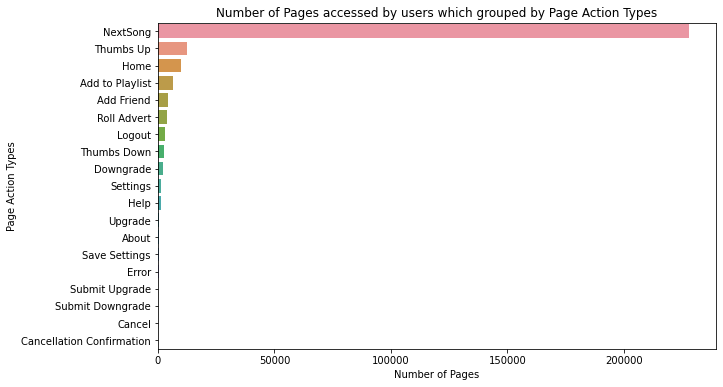

In [0]:
# Check the number of page action in the dataset
pg_action_counts_df = clean_event_df.groupby("page").count().sort(desc("count")).toPandas()
display(pg_action_counts_df.head(6))

plt.figure(figsize=(10,6))
sns.barplot(data=pg_action_counts_df, x='count', y='page')
plt.title('Number of Pages accessed by users which grouped by Page Action Types');
plt.xlabel("Number of Pages")
plt.ylabel("Page Action Types")
plt.show()

The most visited page is the "NextSong", "Thumbs Up", "Home", "Add to Playlist", "Add Friend" and etc

churnFlag,count
0,173
1,52


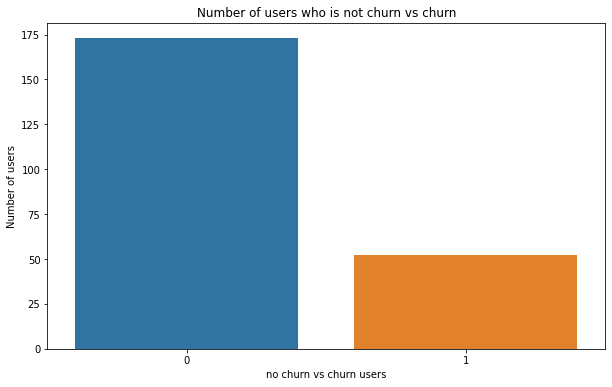

In [0]:
# Number of churn vs no-churn users 
#churn_by_user_df = clean_event_df.groupby(["churnFlag"]).count().sort("churnFlag").toPandas()
churn_by_user_df = clean_event_df.dropDuplicates(['userId']).groupby(["churnFlag"]).count().sort("churnFlag").toPandas()
display(churn_by_user_df)

plt.figure(figsize=(10,6))
sns.barplot(data=churn_by_user_df, x='churnFlag', y='count')
plt.title('Number of users who is not churn vs churn');
plt.xlabel("no churn vs churn users")
plt.ylabel("Number of users")
plt.show()

Number of churn users (52) is much less than non-churn users (173). Thus, we have data imbalance which will force us to choose F1 score in model evaluation rather than based on Accuracy of the model

churnFlag,level,count
0,free,149
0,paid,129
1,paid,36
1,free,46


Out[195]: Text(0, 0.5, 'Number of Users')

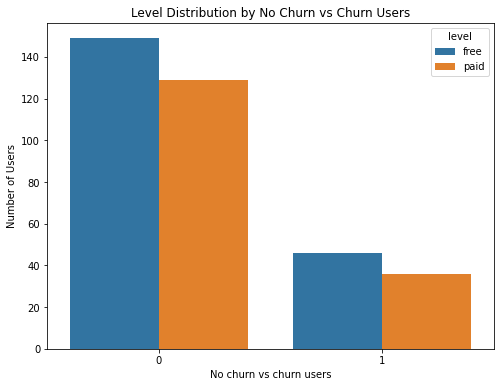

In [0]:
# Level Distribution by User Status Plot
churn_by_level_df = clean_event_df.dropDuplicates(['userId', 'level']).groupby(['churnFlag', 'level']).count() \
            .sort("churnFlag").toPandas()
display(churn_by_level_df)

plt.figure(figsize=(8,6))
sns.barplot(data=churn_by_level_df, x='churnFlag', y='count', hue='level')
plt.title("Level Distribution by No Churn vs Churn Users")
plt.xlabel("No churn vs churn users")
plt.ylabel("Number of Users")

The number of users (Non churn and churn users) subscribe to the "paid" level is much greater than the numbers of users (Non churn and churn users) subscribes to the "free" level

churnFlag,gender,count
0,M,89
0,F,84
1,F,20
1,M,32


Out[196]: Text(0, 0.5, 'Number of Users')

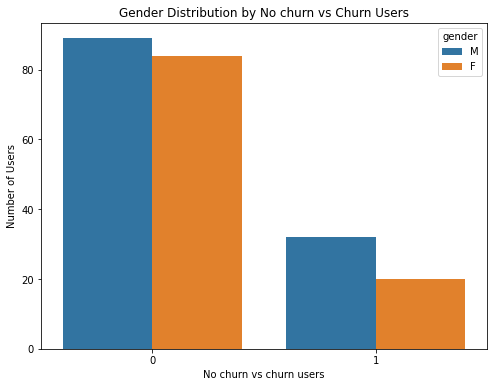

In [0]:
#Compare the genders of users who churned vs not churn
churn_by_gender_df = clean_event_df.dropDuplicates(['userId', 'gender']).groupby(['churnFlag', 'gender']).count() \
                .sort("churnFlag").toPandas()
display(churn_by_gender_df)

plt.figure(figsize=(8,6))
sns.barplot(data = churn_by_gender_df, x='churnFlag', y='count', hue='gender')
plt.title('Gender Distribution by No churn vs Churn Users')
plt.xlabel("No churn vs churn users")
plt.ylabel("Number of Users")

In [0]:
# The above bar chart shows that Male has a more tendency to churn compared to Female.
# Lets calculate the churn ratio for each gender:
churn_percent_by_gender_df = clean_event_df.dropDuplicates(['userId', 'gender']).groupby(['gender']).agg(sum('churnFlag')/countDistinct('userId')).toPandas()
display(churn_percent_by_gender_df)

gender,(sum(churnFlag) / count(userId))
F,0.19230769230769232
M,0.2644628099173554


Churn ratio for Male (0.264) is much higher than churn ratio for female (0.192). Thus the number of males who churn (cancel the services) is much higher than the number of females who churn

churnFlag,avg(length)
0,249.2091353888124
1,248.6327956440613


Out[198]: Text(0, 0.5, 'Average Listened Song Length ')

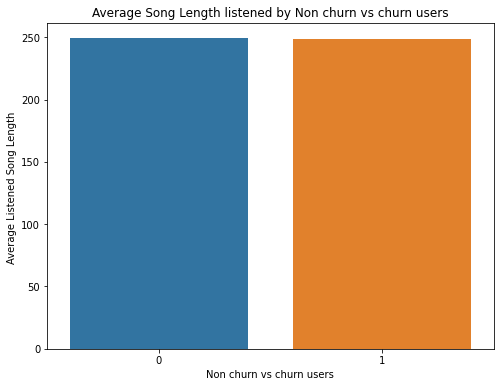

In [0]:
# Average Music Length Listened by No Churn vs Churn Users
churn_length_df = clean_event_df.groupby('churnFlag').avg().select('churnFlag', 'avg(length)') \
                .sort("churnFlag").toPandas()
display(churn_length_df)

plt.figure(figsize=(8,6))
sns.barplot(data=churn_length_df, x='churnFlag', y='avg(length)')
plt.title("Average Song Length listened by Non churn vs churn users")
plt.xlabel("Non churn vs churn users")
plt.ylabel("Average Listened Song Length ")


The average length of the songs listened by Non churn vs churn users is almost the same

churnFlag,count(song)
0,168808
1,33195


Out[199]: Text(0, 0.5, 'Total number of songs listened')

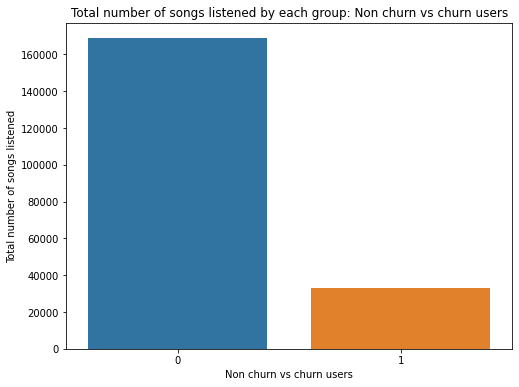

In [0]:
# The total number of songs listened by each group: non churn vs churn users
songs_played_df = clean_event_df.dropDuplicates(['userId', "song"]).where(clean_event_df.page == "NextSong") \
                                .groupby("churnFlag").agg(count("song")).sort("churnFlag").toPandas()
display(songs_played_df)

plt.figure(figsize=(8,6))
sns.barplot(data=songs_played_df, x='churnFlag', y='count(song)')
plt.title("Total number of songs listened by each group: Non churn vs churn users")
plt.xlabel("Non churn vs churn users")
plt.ylabel("Total number of songs listened")

Because there are much more non churn users compared to churn users. Therefore, the total number of songs listened by Non churn users (168808) are much higher than churn users (33195)

In [0]:
#Find the average number of songs played by each group: non churn vs churn users
avg_songs_played_df = clean_event_df.where(clean_event_df.page == "NextSong") \
                                .groupby("churnFlag").agg(count("song")/countDistinct("userId")).sort("churnFlag").toPandas()
display(avg_songs_played_df)

churnFlag,(count(song) / count(userId))
0,1108.1734104046243
1,699.8846153846154


The average number of songs listened by non churn users (1108) is much greater than churn users (699)

churnFlag,hour,count
1,0,1535
0,0,7527
1,1,1353
0,1,7035
1,2,1322
0,2,7014


Out[201]: <matplotlib.legend.Legend at 0x7f2abcb31760>

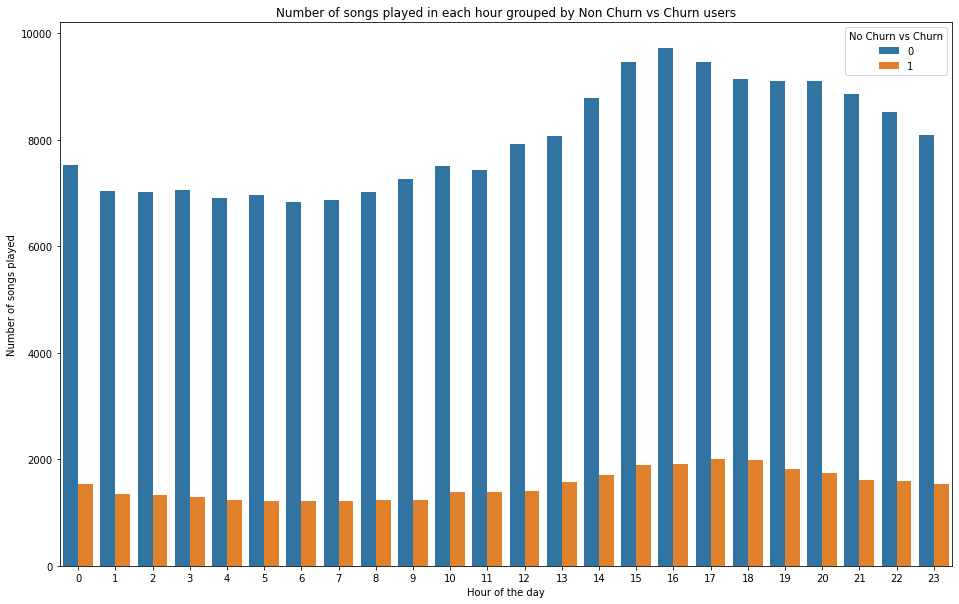

In [0]:
# Count the number of songs in each hour of day
songs_by_hour_df = clean_event_df.where(clean_event_df.page == 'NextSong').groupby('churnFlag','hour').agg(count('hour').alias('count')).sort("hour").toPandas()

display(songs_by_hour_df.head(6))
plt.figure(figsize=(16,10))
sns.barplot(data=songs_by_hour_df, x='hour', y='count', hue="churnFlag")
plt.title("Number of songs played in each hour grouped by Non Churn vs Churn users")
plt.xlabel("Hour of the day")
plt.ylabel("Number of songs played")
plt.legend(title='No Churn vs Churn')

The highest number of songs played in each group (non-churn vs churn users) is between 14 hours to 22 hours

churnFlag,page,count
0,About,439
1,About,56
0,Add Friend,3641
1,Add Friend,636
0,Add to Playlist,5488
1,Add to Playlist,1038


Out[202]: <matplotlib.legend.Legend at 0x7f2a78fbeee0>

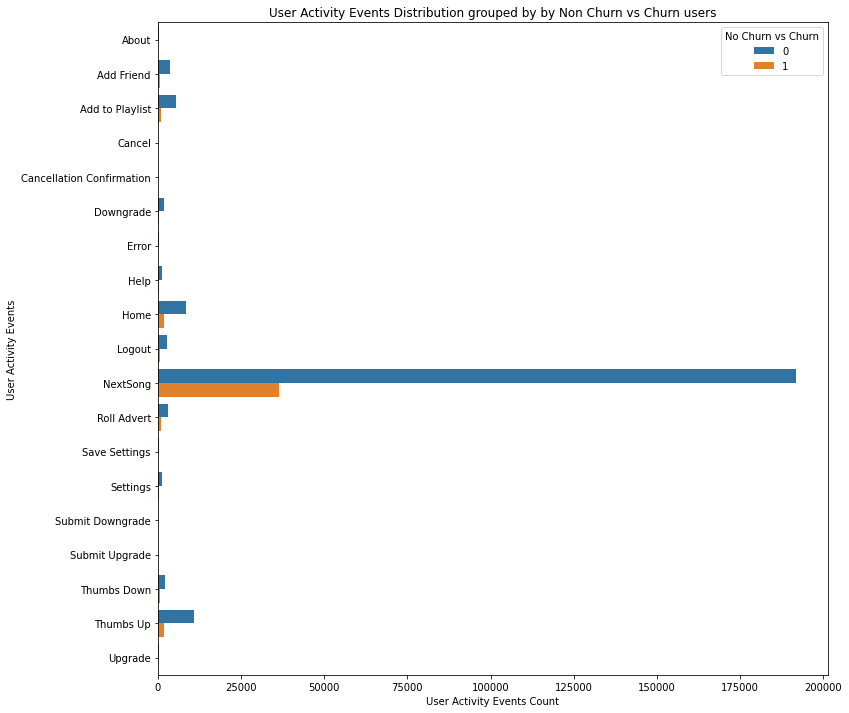

In [0]:
# User Activity Events Distribution by Non Churn vs Churn Users
churn_page_df = clean_event_df.groupby('churnFlag','page').agg(count('page').alias('count')).sort("page").toPandas()
display(churn_page_df.head(6))
                                                      
plt.figure(figsize=(12,12))
sns.barplot(data=churn_page_df, x='count', y='page', hue="churnFlag")
plt.title("User Activity Events Distribution grouped by by Non Churn vs Churn users")
plt.xlabel("User Activity Events Count")
plt.ylabel("User Activity Events")
plt.legend(title='No Churn vs Churn')

Average session time (in hour) spent by each user group (churn vs non-churn) on the platform

In [0]:
avg_sessiontime_churn_df = clean_event_df.where('churnFlag == 1').groupby("userId","sessionId") \
        .agg( ((max(clean_event_df.ts)-min(clean_event_df.ts))/(1000*60*60) ) \
        .alias("sessionLength")).agg({'sessionLength': 'avg'}).toPandas()
display(avg_sessiontime_churn_df)

avg(sessionLength)
4.718692323608524


In [0]:
avg_sessiontime_no_churn_df = clean_event_df.where('churnFlag == 0').groupby("userId","sessionId") \
        .agg( ((max(clean_event_df.ts)-min(clean_event_df.ts))/(1000*60*60) ) \
        .alias("sessionLength")).agg({'sessionLength': 'avg'}).toPandas()
display(avg_sessiontime_no_churn_df)

avg(sessionLength)
5.047589364658335


The average session time of a Non churn users is 5.047 hours vs the average session time of a churn users is 4.718 hours

Average number of registered days by each user group on the platform

In [0]:
max_register_day_churn_df = clean_event_df.where('churnFlag == 1').groupby('userId', 'ts', 'registration').count() \
                    .withColumn('register_days', (clean_event_df.ts - clean_event_df.registration) / (1000*60*60*24) ) \
                    .agg({'register_days' : 'max'}).toPandas()

display(max_register_day_churn_df)

max(register_days)
188.3117824074074


In [0]:
max_register_day_no_churn_df = clean_event_df.where('churnFlag == 0').groupby('userId', 'ts', 'registration').count() \
                    .withColumn('register_days', (clean_event_df.ts - clean_event_df.registration) / (1000*60*60*24) ) \
                    .agg({'register_days' : 'max'}).toPandas()

display(max_register_day_no_churn_df)

max(register_days)
256.3776736111111


The maximum number of days which churn users has registered with the platform is 188.31 days vs the maximum number of days which non churn users has registered with the platform is 256.37 days

##Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

* Write a script to extract the necessary features from the smaller subset of data
* Ensure that your script is scalable, using the best practices discussed in Lesson 3
* Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [0]:
display(clean_event_df.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churnFlag,datetime,day_of_month,day_of_week,hour
null,Cancelled,Mahi,F,17,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",GET,Cancellation Confirmation,1537898335000,191,null,200,1542038645000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:04:05,12,2,16
null,Logged In,Mahi,F,16,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",PUT,Cancel,1537898335000,191,null,307,1542038640000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:04:00,12,2,16
null,Logged In,Mahi,F,15,Robinson,null,free,"Houston-The Woodlands-Sugar Land, TX",GET,Roll Advert,1537898335000,191,null,200,1542038639000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:03:59,12,2,16
Luis Fonsi,Logged In,Mahi,F,14,Robinson,278.17751,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1537898335000,191,Aunque Estes Con El,200,1542038619000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:03:39,12,2,16
Serj Tankian,Logged In,Mahi,F,13,Robinson,174.88934,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1537898335000,191,Elect The Dead (Album Version),200,1542038445000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,100022,1,2018-11-12 16:00:45,12,2,16


In [0]:
# Create a features dataframe.
features_df = clean_event_df.select('userId').dropDuplicates()
display(features_df.head(6))

userId
51
54
138
115
117
141


#### Add Gender as feature

In [0]:
# Define a user-defined function to create a new column to change categorical "gender" column to numeric.
convert_gender_numeric = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
# Apply the udf to create a new numeric column called: 'isMale'
clean_event_df = clean_event_df.withColumn('isMale', convert_gender_numeric(clean_event_df.gender))

# Create a dataframe with 2 columns: userId, isMale
genders_df = clean_event_df.dropDuplicates(['userId']).select(['userId', 'isMale']) \
                                                                .groupby('userId').agg(max('isMale')) \
                                                                .withColumnRenamed('max(isMale)', 'isMale')

# add the gender column into features dataframe
features_df = features_df.join(genders_df, 'userId', 'outer')
display(features_df.head(6))

userId,isMale
10,1
100,1
100001,0
100002,0
100003,0
100004,0


#### Add level as feature

In [0]:
# Define a user-defined function to create a new column to change categorical "level" column to numeric.
convert_gender_numeric = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
# Apply the udf to create a new numeric "level" column
clean_event_df = clean_event_df.withColumn('isPaid', convert_gender_numeric(clean_event_df.level))

# Take the userId info and level for adding the level info into features dataframe
levels_df = clean_event_df.dropDuplicates(['userId']).select(['userId', 'isPaid']) \
                                                                .groupby('userId').agg(max('isPaid')) \
                                                                .withColumnRenamed('max(isPaid)', 'isPaid')

# add the level column into features dataframe
features_df = features_df.join(levels_df, 'userId', 'outer')
display(features_df.head(6))

userId,isMale,isPaid
10,1,1
100,1,1
100001,0,0
100002,0,1
100003,0,0
100004,0,1


#### Add number of days since registration as feature

In [0]:
max_register_days_df = clean_event_df.groupby(['userId', 'ts', 'registration']).count() \
                    .withColumn('register_days', (clean_event_df.ts - clean_event_df.registration) / (1000*60*60*24) ) \
                    .groupBy('userId').agg(max('register_days')) \
                    .withColumnRenamed('max(register_days)', 'max_registration_days')
#display(max_register_days_df)

# add the max_registration_days column into features dataframe
features_df = features_df.join(max_register_days_df, 'userId', 'outer')
display(features_df.head(6))

userId,isMale,isPaid,max_registration_days
10,1,1,51.76265046296297
100,1,1,64.87377314814815
100001,0,0,44.80021990740741
100002,0,1,160.47207175925925
100003,0,0,22.748113425925926
100004,0,0,172.44008101851853


#### Add average session time (in hour) as feature

In [0]:
avg_session_time_df = clean_event_df.groupby(['userId', 'sessionId']) \
        .agg( ((max(clean_event_df.ts)-min(clean_event_df.ts))/(1000*60*60) ) \
        .alias("sessionLength")).groupby(['userId']).agg({'sessionLength': 'avg'}).withColumnRenamed('avg(sessionLength)', 'avg_session_time')
#display(avg_session_time_df)

# add the avg_session_times column into features dataframe
features_df = features_df.join(avg_session_time_df, 'userId', 'outer')
display(features_df.head(6))

userId,isMale,isPaid,max_registration_days,avg_session_time
10,1,1,51.76265046296297,7.662453703703702
100,1,1,64.87377314814815,5.275317460317463
100001,0,0,44.80021990740741,2.4693055555555556
100002,0,1,160.47207175925925,3.3530555555555557
100003,0,0,22.748113425925926,1.6519444444444444
100004,0,1,172.44008101851853,3.0997751322751323


#### Add average songs played per session

In [0]:
avg_songs_played_df = clean_event_df.where(clean_event_df.song.isNotNull()).groupby(['userId', 'sessionId']).count()\
                            .groupby(['userId']).agg({'count': 'avg'}) \
                            .withColumnRenamed('avg(count)', 'avg_songs_played')
#display(avg_songs_played_df)

# add the avg_songs_played column into features dataframe
features_df = features_df.join(avg_songs_played_df, 'userId', 'outer')
display(features_df.head(6))

userId,isMale,isPaid,max_registration_days,avg_session_time,avg_songs_played
10,1,1,51.76265046296297,7.6624537037037035,112.16666666666667
100,1,1,64.87377314814815,5.27531746031746,78.88235294117646
100001,0,0,44.80021990740741,2.4693055555555556,33.25
100002,0,1,160.47207175925925,3.3530555555555557,48.75
100003,0,0,22.748113425925926,1.6519444444444444,25.5
100004,0,0,172.44008101851853,3.099775132275132,47.1


#### Add counts of specific page types per user as features

In [0]:
pages_df = clean_event_df.where(col('page').isin('NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert', 'Error', 'Home'))\
                                                    .groupBy('userId').pivot('page').count().fillna(0)
#display(pages_df)

# add the page action type column into features dataframe
features_df = features_df.join(pages_df, 'userId', 'outer')
display(features_df.head(6))

userId,isMale,isPaid,max_registration_days,avg_session_time,avg_songs_played,Add Friend,Add to Playlist,Error,Home,NextSong,Roll Advert,Thumbs Down,Thumbs Up
10,1,1,51.76265046296297,7.662453703703704,112.16666666666667,12,9,0,30,673,1,4,37
100,1,1,64.87377314814815,5.275317460317461,78.88235294117646,49,61,3,105,2682,25,27,148
100001,0,0,44.80021990740741,2.4693055555555556,33.25,2,3,1,11,133,14,2,8
100002,0,1,160.47207175925925,3.3530555555555557,48.75,1,5,0,6,195,3,0,5
100003,0,0,22.748113425925926,1.6519444444444444,25.5,0,2,0,7,51,9,0,3
100004,0,0,172.44008101851853,3.0997751322751323,47.1,19,23,2,66,942,86,11,35


#### Add churnFlag as label

In [0]:
# Take the userId and churnFlag adding into features dataframe as a label
churn_label_df = clean_event_df.dropDuplicates(['userId']).select(['userId', 'churnFlag']) \
                                                                .groupby('userId').agg(max('churnFlag')) \
                                                                .withColumnRenamed('max(churnFlag)', 'label')
display(churn_label_df.head(6))


userId,label
10,0
100,0
100001,1
100002,0
100003,1
100004,0


In [0]:
# join the features and label
data_df = features_df.join(churn_label_df, 'userId', 'outer').drop("userId")
data_df = data_df.na.fill(0)
display(data_df.head(6))

isMale,isPaid,max_registration_days,avg_session_time,avg_songs_played,Add Friend,Add to Playlist,Error,Home,NextSong,Roll Advert,Thumbs Down,Thumbs Up,label
1,1,64.87377314814815,5.275317460317461,78.88235294117646,49,61,3,105,2682,25,27,148,0
0,0,172.44008101851853,3.0997751322751323,47.1,19,23,2,66,942,86,11,35,0
1,0,85.19559027777778,2.003111111111111,38.5,3,3,0,15,154,18,3,7,1
0,0,9.127164351851851,1.5572222222222223,26.0,4,1,0,2,26,3,2,2,1
0,1,115.38761574074074,3.156851851851852,47.0,17,9,0,20,423,5,6,19,1
0,1,68.22856481481482,8.804212962962964,128.66666666666666,17,30,0,24,772,20,6,37,0


In [0]:
# create columns of all features
feature_cols = data_df.columns
feature_cols.remove("label")

In [0]:
stages = []
# create a feature vector 
vector_assember = VectorAssembler(inputCols=feature_cols, outputCol='features_vec')
# scale the data with Standard Scaler
scaler = StandardScaler(withMean=True, withStd=True, inputCol='features_vec', outputCol='features')
stages += [vector_assember, scaler]

In [0]:
# Create a PipeLine to convert features into a feature vector which has standard scaled values ready for creating model 
processed_data_df = Pipeline(stages = stages).fit(data_df).transform(data_df)
display(processed_data_df.head(6))

isMale,isPaid,max_registration_days,avg_session_time,avg_songs_played,Add Friend,Add to Playlist,Error,Home,NextSong,Roll Advert,Thumbs Down,Thumbs Up,label,features_vec,features
1,1,64.87377314814815,5.275317460317462,78.88235294117646,49,61,3,105,2682,25,27,148,0,"Map(vectorType -> dense, length -> 13, values -> List(1.0, 1.0, 64.87377314814815, 5.275317460317462, 78.88235294117646, 49.0, 61.0, 3.0, 105.0, 2682.0, 25.0, 27.0, 148.0))","Map(vectorType -> dense, length -> 13, values -> List(0.9250319528891594, 1.2220201853215573, -0.39753919143641825, 0.16032951585812863, 0.18989957492402298, 1.4571724752963453, 0.9779592871257721, 1.2766474540775283, 1.2726436936611154, 1.5097247785116819, 0.34895256202012315, 1.1993474999720273, 1.4083796688480137))"
0,0,172.44008101851853,3.099775132275132,47.1,19,23,2,66,942,86,11,35,0,"Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 172.44008101851853, 3.099775132275132, 47.1, 19.0, 23.0, 2.0, 66.0, 942.0, 86.0, 11.0, 35.0))","Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, -0.814680123547705, 2.458597539742965, -0.5777994999818182, -0.5558959707759792, -4.318827727609389E-4, -0.18352868410986514, 0.5975796593554388, 0.4480517707580443, -0.06499174878162245, 3.1795518018110123, -0.02412968900482156, -0.317392805992255))"
1,0,85.19559027777778,2.003111111111111,38.5,3,3,0,15,154,18,3,7,1,"Map(vectorType -> dense, length -> 13, values -> List(1.0, 0.0, 85.19559027777778, 2.003111111111111, 38.5, 3.0, 3.0, 0.0, 15.0, 154.0, 18.0, 3.0, 7.0))","Map(vectorType -> dense, length -> 13, values -> List(0.9250319528891594, -0.814680123547705, 0.14205252178100164, -0.9498812214978003, -0.7577010953018728, -0.777820873742951, -0.7948381426549374, -0.7605559300887403, -0.6302607438075101, -0.7781392335558316, 0.02412969843756215, -0.635868283493246, -0.7450178440057729))"
0,0,9.127164351851851,1.5572222222222223,26.0,4,1,0,2,26,3,2,2,1,"Map(vectorType -> dense, length -> 13, values -> List(0.0, 0.0, 9.127164351851851, 1.5572222222222223, 26.0, 4.0, 1.0, 0.0, 2.0, 26.0, 3.0, 2.0, 2.0))","Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, -0.814680123547705, -1.8777418698965518, -1.1011646612577088, -1.0510224972290438, -0.7292340618073141, -0.8559690885094445, -0.7605559300887403, -0.9051247181085338, -0.8939804493567183, -0.67191929495364, -0.7123356078042989, -0.8213794579367582))"
0,1,115.38761574074074,3.1568518518518522,47.0,17,9,0,20,423,5,6,19,1,"Map(vectorType -> dense, length -> 13, values -> List(0.0, 1.0, 115.38761574074074, 3.1568518518518522, 47.0, 17.0, 9.0, 0.0, 20.0, 423.0, 5.0, 6.0, 19.0))","Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, 1.2220201853215573, 0.9437213214333218, -0.5584342215841104, -0.5582425419913966, -0.09760550664403468, -0.6114453050914157, -0.7605559300887403, -0.5245438306148087, -0.5346916784742805, -0.5791127625014798, -0.4064663105600868, -0.5617499705714081))"
0,1,68.22856481481482,8.804212962962964,128.66666666666666,17,30,0,24,772,20,6,37,0,"Map(vectorType -> dense, length -> 13, values -> List(0.0, 1.0, 68.22856481481482, 8.804212962962964, 128.66666666666666, 17.0, 30.0, 0.0, 24.0, 772.0, 20.0, 6.0, 37.0))","Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, 1.2220201853215573, -0.30846163644430796, 1.3576310488113674, 1.3581239505994538, -0.09760550664403468, 0.03042962638091013, -0.7605559300887403, -0.4399703000606475, -0.21884336351717518, 0.11693623088972244, -0.4064663105600868, -0.28684816041986083))"


## Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods we learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [0]:
# Create a Model data with a feature vector and label which is ready for applying the models
model_data = processed_data_df.select('features', 'label')
display(model_data.head(6))

features,label
"Map(vectorType -> dense, length -> 13, values -> List(0.9250319528891594, 1.2220201853215573, -0.39753919143641825, 0.16032951585812744, 0.18989957492402298, 1.4571724752963453, 0.9779592871257721, 1.2766474540775283, 1.2726436936611154, 1.5097247785116819, 0.34895256202012315, 1.1993474999720273, 1.4083796688480137))",0
"Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, -0.814680123547705, 2.458597539742965, -0.5777994999818182, -0.5558959707759792, -4.318827727609389E-4, -0.18352868410986514, 0.5975796593554388, 0.4480517707580443, -0.06499174878162245, 3.1795518018110123, -0.02412968900482156, -0.317392805992255))",0
"Map(vectorType -> dense, length -> 13, values -> List(0.9250319528891594, -0.814680123547705, 0.14205252178100164, -0.9498812214978003, -0.7577010953018728, -0.777820873742951, -0.7948381426549374, -0.7605559300887403, -0.6302607438075101, -0.7781392335558316, 0.02412969843756215, -0.635868283493246, -0.7450178440057729))",1
"Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, -0.814680123547705, -1.8777418698965518, -1.1011646612577088, -1.0510224972290438, -0.7292340618073141, -0.8559690885094445, -0.7605559300887403, -0.9051247181085338, -0.8939804493567183, -0.67191929495364, -0.7123356078042989, -0.8213794579367582))",1
"Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, 1.2220201853215573, 0.9437213214333218, -0.5584342215841104, -0.5582425419913966, -0.09760550664403468, -0.6114453050914157, -0.7605559300887403, -0.5245438306148087, -0.5346916784742805, -0.5791127625014798, -0.4064663105600868, -0.5617499705714081))",1
"Map(vectorType -> dense, length -> 13, values -> List(-1.0762390990345028, 1.2220201853215573, -0.30846163644430796, 1.3576310488113674, 1.3581239505994538, -0.09760550664403468, 0.03042962638091013, -0.7605559300887403, -0.4399703000606475, -0.21884336351717518, 0.11693623088972244, -0.4064663105600868, -0.28684816041986083))",0


In [0]:
#splitting the data into train and test set
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

#### We will apply four different algorithms for training the models

1. Logistic Regression
2. Support Vector Machine
3. Random Forest Classifier
4. Gradient Boosted Tree Models

In [0]:
# Evaluate the model with accuracy and f1 metrics
def evaluate_models(models, train, test, hyper=False):
    '''
    This function evaluates one or more models with accuracy and f1 metrics
    It also output the accuracy and f1 metrics of each input model 
    
    Input:
    model: fitted model 
    train: train data set
    test: test data set
    hyper is an input indicator, 
    which set to True when input models in the list of models are with hyperparameter tuning
    which set to False when input models in the list of models are without hyperparameter tuning
    
    Output: 
    a data contains the result of the metrics with train and test data
    '''
    # save the results of the model evaluation
    eval_outputs = []
    
    for model in models:      
        # get the result of the metrics for the training data
        preds = model.transform(train)
        evaluator = MulticlassClassificationEvaluator()
        accuracy_train = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
        f1_train = evaluator.evaluate(preds, {evaluator.metricName: "f1"})

        # get the result of the metrics for the test data
        preds = model.transform(test)
        evaluator = MulticlassClassificationEvaluator()
        accuracy_test = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
        f1_test = evaluator.evaluate(preds, {evaluator.metricName: "f1"})
        
        # save the model names in the list and results in the dictionary
        if hyper == True:
          model_name = model.bestModel.__class__.__name__
        else:
          model_name = model.__class__.__name__
                    
        eval_outputs.append([model_name, accuracy_train, f1_train, accuracy_test, f1_test])
               
    # create a dataframe to store the output of the accuracy and f1 metrics
    outputs_df = pd.DataFrame(data = eval_outputs, 
                             columns=['Model_Name', 'Accuracy Train', 'F1 Train', 'Accuracy Test', 'F1 Test'])    
    return outputs_df

### Logistic Regression Classifier

In [0]:
start_time = time.time()
lr = LogisticRegression(maxIter=10)
lr_model = lr.fit(train)
#lr_model.avgMetrics
end_time = time.time()
print("Computational time for Training data in Logisitic Regression (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Logisitic Regression (in minutes): 0.61


### Support Vector Machine Classfier

In [0]:
start_time = time.time()
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model = svm.fit(train)

end_time = time.time()
print("Computational time for Training data in Support Vector Machine  (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Support Vector Machine  (in minutes): 0.7


### Random Forest Classifier

In [0]:
start_time = time.time()
rf = RandomForestClassifier(seed = 42)
rf_model = rf.fit(train)
end_time = time.time()
print("Computational time for Training data in Random Forest Classfier  (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Random Forest Classfier  (in minutes): 0.62


### Gradient Boosted Trees

In [0]:
start_time = time.time()
gbt = GBTClassifier(seed = 42)
gbt_model = gbt.fit(train)
end_time = time.time()
print("Computational time for Training data in Gradient Boosted Trees  (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Gradient Boosted Trees  (in minutes): 1.45


### Evaluate 4 models without hyperparamter tuning

In [0]:
print("Compare 4 models without hyperparamter tuning\n")
models = [lr_model, svm_model, rf_model, gbt_model]
compare_df =  evaluate_models(models, train, test, hyper=False)
display(compare_df)

Compare 4 models without hyperparamter tuning



Model_Name,Accuracy Train,F1 Train,Accuracy Test,F1 Test
LogisticRegressionModel,0.7925531914893617,0.7793426848495685,0.8378378378378378,0.7724437724437724
LinearSVCModel,0.7712765957446809,0.6862178469355351,0.6216216216216216,0.651975051975052
RandomForestClassificationModel,0.8723404255319149,0.8785051195170606,0.8648648648648649,0.8335853335853335
GBTClassificationModel,0.9574468085106383,0.9566106756252332,0.9459459459459459,0.9726503997603742


### Logistic Regression Classifier with hyperparameter tuning

In [0]:
# Create an evaluator for comparing accuracy of different algorithms
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

In [0]:
start_time = time.time()
# Define the model
tune_lr = LogisticRegression()

# Define the parameter alternatives to be tested
paramGrid_tune_lr = ParamGridBuilder() \
            .addGrid(tune_lr.regParam, [0.0, 0.05, 0.1]) \
            .addGrid(tune_lr.maxIter, [10, 50]) \
            .build()


# Define cross-validation
crossval_tune_lr = CrossValidator(estimator = tune_lr,
                          estimatorParamMaps = paramGrid_tune_lr,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
tune_lr_model = crossval_tune_lr.fit(train)

end_time = time.time()
print("Computational time for Training data in Logisitic Regression with hyperparameter tuning (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Logisitic Regression with hyperparameter tuning (in minutes): 4.05


### Support Vector Machine Classfier with hyperparameter tuning

In [0]:
start_time = time.time()

# Define the model
tune_svm = LinearSVC()

# Define the parameter alternatives to be tested
paramGrid_tune_svm = ParamGridBuilder() \
            .addGrid(tune_svm.regParam, [0.01, 0.05, 0.5]) \
            .addGrid(tune_svm.maxIter, [5]) \
            .build()
        
# Define cross-validation
crossval_tune_svm = CrossValidator(estimator = tune_svm,
                          estimatorParamMaps = paramGrid_tune_svm,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
tune_svm_model = crossval_tune_svm.fit(train)

end_time = time.time()
print("Computational time for Training data in Support Vector Machine with hyperparameter tuning (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Support Vector Machine with hyperparameter tuning (in minutes): 2.14


### Random Forest Classifier with hyperparameter tuning

In [0]:
start_time = time.time()

# Define the model
tune_rf = RandomForestClassifier(seed = 42)

# Define the parameter alternatives to be tested
paramGrid_tune_rf = ParamGridBuilder() \
            .addGrid(tune_rf.numTrees, [20, 30]) \
            .addGrid(tune_rf.maxDepth, [5, 10]) \
            .build()


# Define cross-validation
crossval_tune_rf = CrossValidator(estimator = tune_rf,
                          estimatorParamMaps = paramGrid_tune_rf,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
tune_rf_model = crossval_tune_rf.fit(train)

end_time = time.time()
print("Computational time for Training data in Random Forest Classfier with hyperparameter tuning (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Random Forest Classfier with hyperparameter tuning (in minutes): 2.66


### Gradient Boosted Trees with hyperparameter tuning

In [0]:
start_time = time.time()

# Define the model
tune_gbt = GBTClassifier(seed = 42)

# Define the parameter alternatives to be tested
paramGrid_tune_gbt = ParamGridBuilder() \
            .addGrid(tune_gbt.maxDepth, [5, 10]) \
            .addGrid(tune_gbt.maxIter, [10, 20]) \
            .build()
        

# Define cross-validation
crossval_tune_gbt = CrossValidator(estimator = tune_gbt,
                        estimatorParamMaps = paramGrid_tune_gbt,
                        evaluator = evaluator,
                        numFolds =3)

# Train the model with train dataset
tune_gbt_model = crossval_tune_gbt.fit(train)

end_time = time.time()
print("Computational time for Training data in Gradient Boosted Trees hyperparameter tuning (in minutes): {}".format( round((end_time-start_time)/60,2)) )

Computational time for Training data in Gradient Boosted Trees hyperparameter tuning (in minutes): 13.98


### Evaluate 4 models with hyperparamter tuning

In [0]:
print("Compare 4 models with hyperparamter tuning\n")
models = [tune_lr_model, tune_svm_model, tune_rf_model, tune_gbt_model]
compare_df =  evaluate_models(models, train, test, hyper=True)
display(compare_df)

Compare 4 models with hyperparamter tuning



Model_Name,Accuracy Train,F1 Train,Accuracy Test,F1 Test
LogisticRegressionModel,0.7925531914893617,0.7704110381568521,0.8648648648648649,0.9169033440219883
LinearSVCModel,0.8031914893617021,0.7476074341939282,0.7567567567567568,0.6746226746226746
RandomForestClassificationModel,0.9521276595744681,0.9560402884558078,0.972972972972973,0.9725844442825575
GBTClassificationModel,0.9521276595744681,0.9565091284740849,1.0,1.0


## Conclusion
I have applied 4 different Machine Learning classification algorithms to predict which users will churn:
1. LogisticRegressionModel
2. LinearSVCModel (SVM)
3. RandomForestClassificationModel
4. GBTClassificationModel (Gradient-Boosted Tree Classification)

The highest performance is from Gradient-Boosted Tree Classification and random forest classification with an f1 score OVER 97 percent.

## Summary
In this project, we start by study the Sparkify streaming service's user event dataset. Since each user event is associated with a specific user, the user event has empty userId does not convey meaningful information when we want to predict the specific users will churn (leave/cancel the streaming services) or not. Thus, we delete user event records in which the userId is a empty string as part of the "data cleaning" process.
We found that there are 225 users in total. There are 52 users who had the “Cancellation Confirmation” user event. We create a "churnFlag" to indicate the user will churn or not based on the specific users have who had the “Cancellation Confirmation” user event or not. We will use F1 scores to evaluate the model performance because of the data imbalance between churn va non-churnusers.
Once we have defined churn, perform some "exploratory data analysis" to observe the behavior for users who stayed vs users who churned. We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played and how it impacted churn. For example:
* Gender Distribution of No churn vs Churn Users
* The average length of the songs listened by Non churn vs churn users
* The average number of songs listened by non churn vs churn users
* User Activity Events Distribution grouped by page-action between Non Churn vs Churn users

The main point here is to find features that might be used for the churn model prediction. We then went ahead to create features that were later used in building these four machine learning models namely: Logistic regression, Support Vector Machine(SVM), RandomForest Classification and Gradient Boosted Tree (GBT).
We then fine-tune these four machine learning models by applying hyperparameters to each model and use 3-fold cross validation to identify the optimal hyperparameters.
Amongst the four models, the GBT performed best with the best f1 scores and accuracy although it took the longest time to train.

### Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.